# 13 图像配准

一张图片可能经过一个平移 / 旋转 / 拉伸变成另一张图像, 导致矩阵每个像素值差异很大, 不能直接比较. 

为了发现前后两张图片的相似性, 需要进行图像配准 (image registration).


### SSD

两张图片的表面上的距离可以简单地用 SSD (sum of square difference) 指标衡量:
$${\rm SSD}= \frac 1N\sum_{ij} (a_{ij} - b_{ij})^2$$

In [89]:
def SSD(img_A, img_B):
    """Sum of square difference between two images."""
    return ((img_A - img_B) ** 2).mean()

## 优化

实际上由于图像相差一个仿射变换, 需要先进行合适的仿射变换后再衡量. 假设两图为 $A,B$, 则需要找到仿射变换 $T$ 使
$$\min_T \ {\rm SSD}(A, T(B))$$

### 梯度下降

可以采用梯度下降方法来寻找这样的 $T$: 假设第 $k$ 步时得到 $T_k$, 则 $k+1$ 步时更新为 
$$T_{k+1} = T_k - \eta \nabla T_k$$

其中 $\eta$ 为学习率, 对矩阵 $(i,j)$ 元素, 梯度 $\nabla_{ij} T_k = \dfrac{\partial }{\partial T_{ij}}{\rm SSD}$ 可近似为 ($\Delta t\in \mathbb R$, $\Delta t\rightarrow 0$)
$$\nabla_{ij} T_k\approx  \frac{{\rm SSD}(A,(T+\Delta t E_{ij})(B)) - {\rm SSD}(A,(T-\Delta t E_{ij})(B))}{2\Delta t}$$

此处 $T+\Delta t E_{ij}$ 表示矩阵 $T$ 的 $(i,j)$ 元素增加 $\Delta t$.

### 变换分解

可以将仿射变换 $T$ 分解为旋转变换、伸缩变换、错切变换、平移变换的复合. 虽然参数更多, 但是每个参数的意义更明显.

In [228]:
import numpy as np
def registration(img_A, img_B, metric, lr_rot = 1e-6, lr_trans = 1e-2, 
                    iters = 100, step = 1e-6, verbose = 10):
    """Perform affine transformation on image B to match image A."""
    affine = np.eye(3) # initialization
    ssds = []

    for iter in range(1, 1 + iters):
        for i in range(2): # only 2 x 3 entries in the affine matrix need training
            for j in range(3):
                # train (i,j) element of the affine matrix
                affine[i,j] += step
                loss1 = metric(img_A, img_B, affine)

                affine[i,j] -= step * 2
                loss2 = metric(img_A, img_B, affine)

                affine[i,j] += step # restore
                grad = (loss1 - loss2) / (2 * step)

                # the learning rate of rotation should be much smaller than translation
                lr = lr_rot if j != 2 else lr_trans
                affine[i,j] -= lr * grad
        ssds.append((loss1 + loss2) / 2)
        if verbose and iter % verbose == 0: print('Iter %03d\tSSD = %.6f'%(iter, ssds[-1]))
    return {'affine': affine, 'loss': ssds}


### 反向变换

欲计算图 $A,T(B)$ 的 ${\rm SSD}$ 指标, 只需要对每个点 $(x,y)$, 求出 $A(x,y)$ 与 $(T(B))(x,y)$ 的像素差值. 注意 $T(B)$ 在 $(x,y)$ 的像素值等于 $B$ 在 $T^{-1}(x,y)$ 处的像素值. 即

$${\rm SSD}(A,T(B)) = \frac 1N\sum_{x,y}\left(A(x,y) - T(B)(x,y)\right)^2
=\frac 1N\sum_{x,y}\left(A(x,y) - B(T^{-1}(x,y)\right)^2$$

假设 $T^{-1}(x,y) = (x',y')$, 也就是要求出每个 $\left(A(x,y) - B(x',y')\right)^2$.

### 图像插值

由于上述 $T^{-1}(x,y) = (x',y')$ 可能不是整点, 可以采用周围几个整点插值求得 $(x',y')$ 的像素值.

In [90]:
import numpy as np
def affine_img(img, affine):
    """Compute the affine transform of a grayscale image."""
    # 1. construct the original coordinates
    h, w, d = img.shape[0], img.shape[1], img.size // (img.shape[0] * img.shape[1])
    coors = np.stack(np.meshgrid(np.arange(w), np.arange(h)))
    coors = np.transpose(coors, (1, 2, 0)).reshape((-1, 2))   # shape: (hw) x 2

    # 2. compute the inversed transformed coordinates
    affine = np.linalg.inv(affine)
    coors2 = coors @ affine[:2,:2] + affine[:2,-1]

    # 3. inquire the interpolated pixel
    coors2_grid = coors2.astype('int32')
    coors2_offs = coors2 - coors2_grid
    reference = lambda coor_x, coor_y: img[np.clip(coor_y, 0, h-1), np.clip(coor_x, 0, w-1)]
    img2 = np.prod(1 - coors2_offs, axis = 1) * reference(coors2_grid[:,0], coors2_grid[:,1])\
        + (1 - coors2_offs[:,0]) * coors2_offs[:,1] * reference(coors2_grid[:,0], coors2_grid[:,1] + 1)\
        + (1 - coors2_offs[:,1]) * coors2_offs[:,0] * reference(coors2_grid[:,0] + 1, coors2_grid[:,1])\
        + np.prod(coors2_offs, axis = 1) * reference(coors2_grid[:,0] + 1, coors2_grid[:,1] + 1)
    img2 = img2.reshape(img.shape)
    return img2

def SSD_affine(img_A, img_B, affine):
    """Compute the SSD between img_A and affine(img_B)."""
    return SSD(img_A, affine_img(img_B, affine))

## 实验

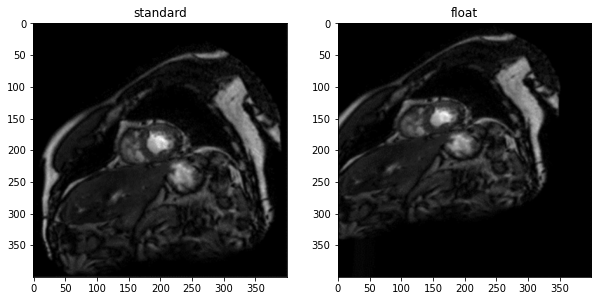

In [197]:
# 试验一下 心脏图像配准 https://zmiclab.github.io/zxh/0/myops20/ 
import os
from matplotlib import pyplot as plt
from PIL import Image

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\heart.png')).resize((400, 400)).convert('L'))
img_B = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\heart_float.png')).resize((400, 400)).convert('L'))
# img_B = affine_img(img, np.array([[.9,.2,10],[-.2,.9,-20],[0,0,1]]))

plt.figure(figsize = (10, 5))
for i, image, title in zip((1, 2), (img, img_B), ('standard', 'float')):
    plt.subplot(1, 2, i)
    plt.imshow(image, cmap = 'gray')
    plt.title(title)
plt.show()

In [205]:
# around 2 minutes
result = registration(img, img_B, metric = SSD_affine, lr_rot = 1e-6, lr_trans = .15, iters = 140, step = 1e-6, verbose = 20)

Iter 020	SSD = 1057.019088
Iter 040	SSD = 526.664852
Iter 060	SSD = 428.642949
Iter 080	SSD = 291.626761
Iter 100	SSD = 282.032858
Iter 120	SSD = 279.332231
Iter 140	SSD = 278.828180


Affine Transformation =
 [[ 1.03145904  0.05801848 17.40125054]
 [ 0.10114661  1.13513391 11.2687352 ]
 [ 0.          0.          1.        ]]


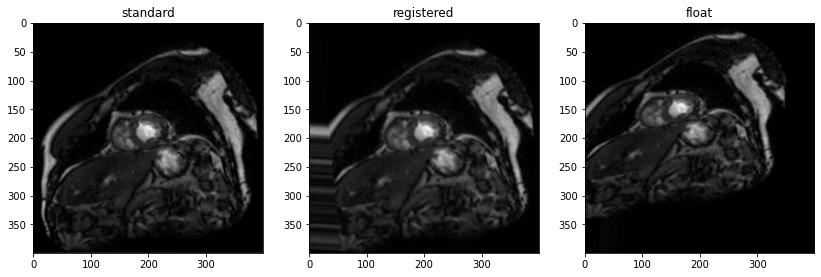

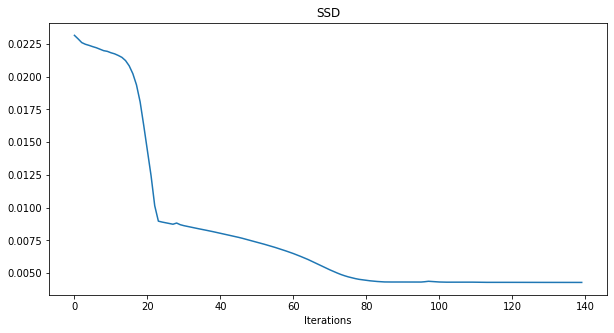

In [227]:
print('Affine Transformation =\n', result['affine'])

img_regis = affine_img(img_B, result['affine'])
plt.figure(figsize = (14, 5))
for i, image, title in zip(range(1, 4), (img, img_regis, img_B), ('standard', 'registered', 'float')):
    plt.subplot(1, 3, i)
    plt.imshow(image, cmap = 'gray')
    plt.title(title)
plt.show()

plt.figure(figsize = (10, 5))
plt.plot(np.array(result['loss']) / 255**2) # normalize SSD
plt.title('SSD')
plt.xlabel('Iterations')
plt.show()